</div>
<div align="left">
  <img src="img/abstract.png" width="400" alt="Funny little diagram">
  <p><em> Evolve nodes, evolve plans, and learn from the best performing ones.</em></p>
</div>
<div align="center">
</em></p>
</div>

#### Node Initialization (Refactoring ...)

In [2]:
from methods.llm import get_async_vllm_endpoint
import os 

# Unlimited LLM endpoints
endpoint_id = "vllm-pojhdn0519f6ax"
api_key = ""
get_endpoint_response = get_async_vllm_endpoint(endpoint_id, api_key)

In [10]:
from methods.meta_prompt import MetaPrompt, PromptMode
from methods.evolnode import EvolNode
from methods.llm import get_groq_response, get_claude_response

# Code + Compilor Task
# mp = MetaPrompt("Search for age of a celebrity.", "get_celeb_age", ["name"], ["age"], ["str"], ["int"], PromptMode.CODE)
# Prompt + LLM Task
mp = MetaPrompt("Get the age of a celebrity.", "get_celeb_age", ["name"], ["age"], ["str"], ["int"], PromptMode.PROMPT) # 

test_cases = [
    ({"name": "Dilireba"}, {"age": 32}),
    ({"name": "ChengXiao"}, {"age": 26})
]

test_inputs = [c[0] for c in test_cases]

node = EvolNode(mp, None, None, get_response=get_endpoint_response, test_cases=test_cases) # setting manual test cases

node.evolve("i1", replace=True, batch_size=20, num_runs=2, print_summary=True) # Scale up batch size


input_dict = {"name": "Dilireba"}
node.get_response = get_groq_response # fast sequential inference 
output_dict = node(input_dict) # use node as a function
print("Output dict: ", output_dict)

KeyboardInterrupt: 

</div>
<div align="center">
  <img src="img/Project-Nirvana-evolve.gif" width="500" alt="Fourier reconstruction convergence">
  <p><em> Evolve a population of nodes. </em></p>
</div>

In [ ]:
# Population building phase ... 
from methods.llm import get_groq_response, get_claude_response
from methods.meta_prompt import MetaPrompt, PromptMode
from methods.population import Evolution

mp = MetaPrompt("Get the age of a celebrity.", "get_celeb_age", ["name"], ["age"], ["str"], ["int"], PromptMode.PROMPT) # 

test_cases = [
    ({"name": "Dilireba"}, {"age": 32}),
    ({"name": "ChengXiao"}, {"age": 26})
]

evo = Evolution(pop_size=20, meta_prompt=mp, get_response=get_endpoint_response, 
                test_cases=test_cases, max_attempts=3, num_eval_runs=2,
                load=True)

strategies = ["m2"] # ["i1", "i1", "m2", "e2"]
evo.get_offspring(strategies)

evo.chat("How effective is the current evolution strategy? What improvement has it made in terms of fitness, and in terms of the implementation?",
         get_claude_response) 

# code-based check 
print(evo.population_info)

Processing queries: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


 :: Total time elapsed: 16.71s, 0 errors


Processing queries: 100%|██████████| 34/34 [00:28<00:00,  1.19it/s]


 :: Total time elapsed: 28.46s, 0 errors


Processing queries: 0it [00:00, ?it/s]


 :: Total time elapsed: 0.00s, 0 errors
🏆 Best Code Performance Summary 🏆
  ⚡ Structural fitness: 0.33
  🎯 Functional fitness: 1.00
  ⭐ Global fitness:     0.67
  🔄 Batch size:        17
  ⏱️ Time taken: 85.64 seconds


📊 Code 0: Fitness: 16.7%
--------------------------------------------------------------------------------
❌ Error Messages:
Input: {'name': 'Dilireba'}, prediction is not aligned with expected output, Expected: {'age': 32} Predicted: {'age': 87}, Error message: 
Value mismatch for key age: 87 != 32


Input: {'name': 'ChengXiao'}, prediction is not aligned with expected output, Expected: {'age': 26} Predicted: {'age': 33}, Error message: 
Value mismatch for key age: 33 != 26




📊 Code 1: Fitness: 0.0%
--------------------------------------------------------------------------------
❌ Error Messages:
Failed to parse LLM response -- No JSON structure found in the provided text.
Failed to parse LLM response -- JsonDecodeError : 
Expecting value: line 1 column 1 (char 0)AstL


</div>
<div align="center">
  <img src="https://github.com/user-attachments/assets/af98faeb-66d6-4278-af86-67d668d1954e" width="900" alt="Fourier reconstruction convergence">
  <p><em> Plan, and evolve the plans. </em></p>
</div>


In [3]:
from methods.llm import get_claude_response, get_groq_response
from methods.diagram import visualize_plan_dict
from methods.meta_prompt import MetaPlan
from methods.evolnode import PlanNode


# Initialize PlanNode 
mp = MetaPlan("Get the age of celebrity.", "get_celeb_age", ["name"], ["age"], ["str"], ["int"])
plan = PlanNode(mp, get_groq_response)

# i1 evolution of plan
# plan_dicts, err_msg = plan.evolve_plan_dict(method="i1", batch_size=1) # Batch_size of 100 gives no slow-down

# for plan_dict in plan_dicts:
#     visualize_plan_dict(plan_dict, plan.meta_prompt.task)
#     break

# Manual input on main-node test cases 
main_test_cases = [
    ({"name": "Dilireba"}, {"age": 32}),
    ({"name": "ChengXiao"}, {"age": 26})
]

is_success, err_msg = plan.spawn_test_cases(main_test_cases) #  pinned test cases generation

 :: Evolving 20 plans in parallel...


Processing LLM queries: 100%|██████████| 20/20 [01:05<00:00,  3.26s/it]


 :: Total time elapsed: 65.13s, 0 errors
 :: Pseudo-code generated for each plan


Processing LLM queries: 100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


 :: Total time elapsed: 21.65s, 0 errors
 :: Plan_dict generated for each plan


success: successfully compiled d2_output/plan_graph.d2 to d2_output/plan_graph.png in 199.177334ms
Processing LLM queries: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]

 :: Total time elapsed: 28.50s, 0 errors
Spawned 1 test cases for all sub-nodes


In [12]:
# plan.test_cases_dict
from methods.evolnode import spawn_test_cases, SPAWN_TEST_MAX_TRIES

test_cases_dict, err_msg = spawn_test_cases(plan.plan_dict, main_test_cases, plan.get_response, SPAWN_TEST_MAX_TRIES)
# print(err_msg)
# test_cases_dict


Processing LLM queries: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]

 :: Total time elapsed: 19.11s, 0 errors


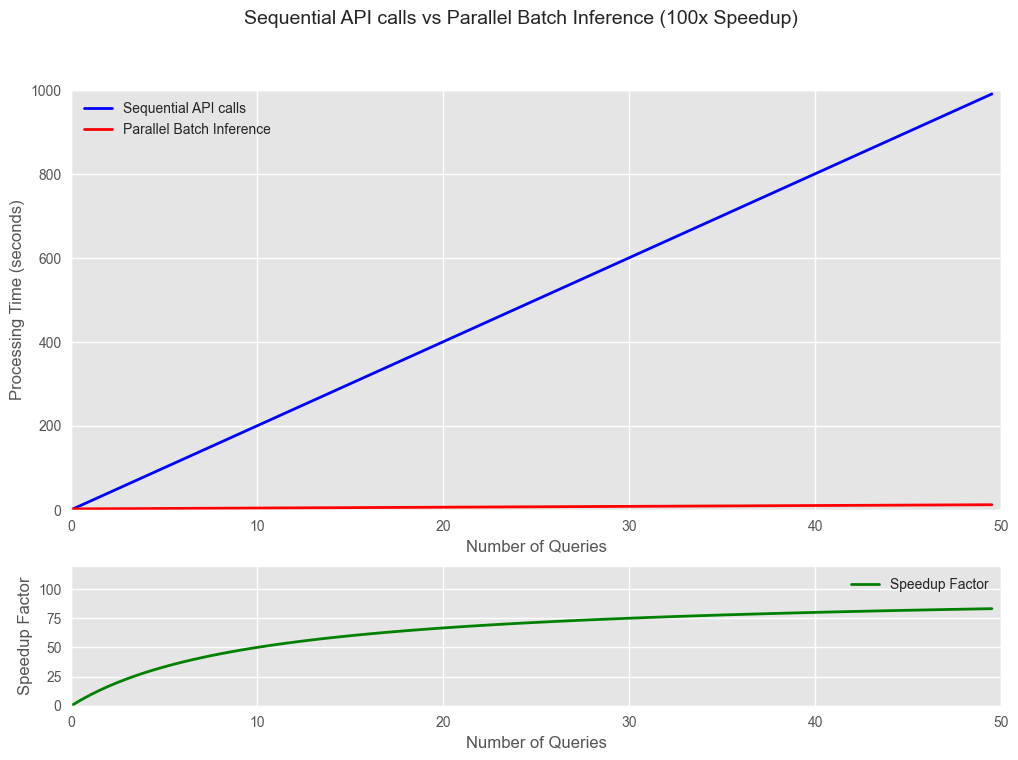

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.style as style

# Option 1: Import seaborn first
import seaborn as sns
style.use('seaborn-v0_8')  # or any other available seaborn style

# OR Option 2: Use a built-in matplotlib style instead
style.use('ggplot')  # or 'fivethirtyeight', 'bmh', etc.

# Data generation
queries = np.linspace(0, 50, 100)
sequential_time = queries * 20  # Linear growth for sequential
parallel_time = queries * 0.2 + 2  # Much slower growth for parallel
speedup_factor = sequential_time / parallel_time

# Create figure and axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[3, 1])
fig.suptitle('Sequential API calls vs Parallel Batch Inference (100x Speedup)', fontsize=14)

# For animation
line_seq, = ax1.plot([], [], 'b-', label='Sequential API calls', linewidth=2)
line_par, = ax1.plot([], [], 'r-', label='Parallel Batch Inference', linewidth=2)
line_speedup, = ax2.plot([], [], 'g-', label='Speedup Factor', linewidth=2)

# Set up axes
ax1.set_xlim(0, 50)
ax1.set_ylim(0, 1000)
ax1.set_xlabel('Number of Queries')
ax1.set_ylabel('Processing Time (seconds)')
ax1.legend()
ax1.grid(True)

ax2.set_xlim(0, 50)
ax2.set_ylim(0, 120)
ax2.set_xlabel('Number of Queries')
ax2.set_ylabel('Speedup Factor')
ax2.legend()
ax2.grid(True)

def init():
    line_seq.set_data([], [])
    line_par.set_data([], [])
    line_speedup.set_data([], [])
    return line_seq, line_par, line_speedup

def animate(frame):
    x = queries[:frame]
    y_seq = sequential_time[:frame]
    y_par = parallel_time[:frame]
    y_speedup = speedup_factor[:frame]
    
    line_seq.set_data(x, y_seq)
    line_par.set_data(x, y_par)
    line_speedup.set_data(x, y_speedup)
    
    return line_seq, line_par, line_speedup

# Create animation
anim = FuncAnimation(fig, animate, init_func=init, frames=len(queries),
                    interval=50, blit=True)

# Save animation
anim.save('speedup_animation.gif', writer='pillow')

# For static plot
plt.show()

In [4]:
import json

with open('./methods/plans/get_celeb_age_plan.json') as f:
    d = json.load(f)


In [5]:
plan.plan_dict = d['plan_dict']

In [6]:
plan.spawn_test_cases_majority(main_test_cases)

Here is a execution plan for a function: 
Nodes:
- Task: Check if input is empty
  Name: is_empty
  Inputs: in_str (str)
  Outputs: result (bool)

- Task: Validate celebrity name
  Name: validate_name
  Inputs: name (str)
  Outputs: result (bool)

- Task: Use web scraping techniques to extract age from the web
  Name: get_age_from_web
  Inputs: name (str)
  Outputs: age (int)

- Task: Extract the celebrity's age from web data
  Name: scrape_celeb_data
  Inputs: name (str)
  Outputs: data (str)

- Task: Main function logic
  Name: get_celeb_age
  Inputs: name (str)
  Outputs: age (int)

Execution Flow:
- is_empty → get_celeb_age
- validate_name → get_celeb_age
- get_celeb_age → validate_name
- get_age_from_web → get_celeb_age
- scrape_celeb_data → get_age_from_web


 help generate test cases for each sub-function by filling the ... with proper inputs and outputs, output JSON like this: 
```json
[
    {
        "name": "is_empty",
        "inputs": [
            {
                "name":

Getting outputs from multiple LLMs:  17%|█▌       | 1/6 [00:03<00:15,  3.14s/it]

meta-llama/llama-3-70b-instruct:nitro response: 

Here is the completed test case JSON:

```json
[
    {
        "name": "is_empty",
        "inputs": [
            {
                "name": ""
            },
            {
                "name": "ChengXiao"
            }
        ],
        "outputs": [
            {
                "result": true
            },
            {
                "result": false
            }
        ]
    },
    {
        "name": "validate_name",
        "inputs": [
            {
                "name": "ChengXiao"
            },
            {
                "name": " invalid_name"
            }
        ],
        "outputs": [
            {
                "result": true
            },
            {
                "result": false
            }
        ]
    },
    {
        "name": "get_age_from_web",
        "inputs": [
            {
                "name": "ChengXiao"
            },
            {
                "name": "Dilireba"
            }
       

Getting outputs from multiple LLMs:  33%|███      | 2/6 [00:08<00:17,  4.40s/it]

mistralai/mistral-large response: ```json
[
    {
        "name": "is_empty",
        "inputs": [
            {
                "name": "Dilireba"
            },
            {
                "name": ""
            }
        ],
        "outputs": [
            {
                "result": false
            },
            {
                "result": true
            }
        ]
    },
    {
        "name": "validate_name",
        "inputs": [
            {
                "name": "Dilireba"
            },
            {
                "name": "12345"
            }
        ],
        "outputs": [
            {
                "result": true
            },
            {
                "result": false
            }
        ]
    },
    {
        "name": "get_age_from_web",
        "inputs": [
            {
                "name": "Dilireba"
            },
            {
                "name": "ChengXiao"
            }
        ],
        "outputs": [
            {
                "age": 32


Getting outputs from multiple LLMs:  50%|████▌    | 3/6 [00:09<00:08,  2.92s/it]

openai/gpt-4o-mini response: ```json
[
    {
        "name": "is_empty",
        "inputs": [
            {
                "name": "Dilireba"
            },
            {
                "name": "ChengXiao"
            }
        ],
        "outputs": [
            {
                "result": false
            },
            {
                "result": false
            }
        ]
    },
    {
        "name": "validate_name",
        "inputs": [
            {
                "name": "Dilireba"
            },
            {
                "name": "ChengXiao"
            }
        ],
        "outputs": [
            {
                "result": true
            },
            {
                "result": true
            }
        ]
    },
    {
        "name": "get_age_from_web",
        "inputs": [
            {
                "name": "Dilireba"
            },
            {
                "name": "ChengXiao"
            }
        ],
        "outputs": [
            {
                "a

Getting outputs from multiple LLMs:  67%|██████   | 4/6 [00:11<00:05,  2.72s/it]

anthropic/claude-3.5-sonnet response: I'll help fill in the test cases while maintaining consistency with the given inputs/outputs and following the execution flow. Here's the completed JSON:

```json
[
    {
        "name": "is_empty",
        "inputs": [
            {
                "name": "Dilireba"
            },
            {
                "name": "ChengXiao"
            }
        ],
        "outputs": [
            {
                "result": false
            },
            {
                "result": false
            }
        ]
    },
    {
        "name": "validate_name",
        "inputs": [
            {
                "name": "Dilireba"
            },
            {
                "name": "ChengXiao"
            }
        ],
        "outputs": [
            {
                "result": true
            },
            {
                "result": true
            }
        ]
    },
    {
        "name": "get_age_from_web",
        "inputs": [
            {
              

Getting outputs from multiple LLMs:  83%|███████▌ | 5/6 [00:25<00:06,  6.72s/it]

microsoft/wizardlm-2-8x22b response:  Certainly! Below is the JSON with the ... filled in for each sub-function based on the provided execution plan and the constraints given:

```json
[
    {
        "name": "is_empty",
        "inputs": [
            {
                "in_str": "Dilireba"
            },
            {
                "in_str": "ChengXiao"
            }
        ],
        "outputs": [
            {
                "result": false
            },
            {
                "result": false
            }
        ]
    },
    {
        "name": "validate_name",
        "inputs": [
            {
                "name": "Dilireba"
            },
            {
                "name": "ChengXiao"
            }
        ],
        "outputs": [
            {
                "result": true
            },
            {
                "result": true
            }
        ]
    },
    {
        "name": "get_age_from_web",
        "inputs": [
            {
                "name": "D

Getting outputs from multiple LLMs: 100%|█████████| 6/6 [00:31<00:00,  5.22s/it]

deepseek/deepseek-chat response: ```json
[
    {
        "name": "is_empty",
        "inputs": [
            {
                "in_str": "Dilireba"
            },
            {
                "in_str": ""
            }
        ],
        "outputs": [
            {
                "result": false
            },
            {
                "result": true
            }
        ]
    },
    {
        "name": "validate_name",
        "inputs": [
            {
                "name": "Dilireba"
            },
            {
                "name": "InvalidName123"
            }
        ],
        "outputs": [
            {
                "result": true
            },
            {
                "result": false
            }
        ]
    },
    {
        "name": "get_age_from_web",
        "inputs": [
            {
                "name": "Dilireba"
            },
            {
                "name": "ChengXiao"
            }
        ],
        "outputs": [
            {
              

(True,
 "\n\nOutput mismatch for input {'name': 'ChengXiao'}, expected {'age': 26}, got {'age': 32}\n\n\n")

In [7]:
plan.test_cases_dict

{'is_empty': [({'name': 'Dilireba'}, {'result': False}),
  ({'name': 'ChengXiao'}, {'result': False})],
 'validate_name': [({'name': 'Dilireba'}, {'result': True}),
  ({'name': 'ChengXiao'}, {'result': True})],
 'get_age_from_web': [({'name': 'Dilireba'}, {'age': 32}),
  ({'name': 'ChengXiao'}, {'age': 26})],
 'scrape_celeb_data': [({'name': 'Dilireba'},
   {'data': 'Dilireba (born 3 June 1992) is a Chinese actress...'}),
  ({'name': 'ChengXiao'},
   {'data': 'Cheng Xiao (born July 15, 1998) is a Chinese singer...'})],
 'get_celeb_age': [({'google_result': 'Dilireba (born 3 June 1992) is a Chinese actress...'},
   {'age': 32}),
  ({'google_result': 'Cheng Xiao (born July 15, 1998) is a Chinese singer...'},
   {'age': 26})]}

In [ ]:
# plan.evolve_sub_nodes() # Completely stuck in the first call, debugging ... 

from methods.evolnode import EvolNode
from methods.meta_prompt import MetaPrompt, PromptMode

self = plan 
for i, node_dict in enumerate(self.plan_dict["nodes"]):
    meta_prompt = MetaPrompt(
        task=node_dict["task"],
        func_name=node_dict["name"],
        inputs=node_dict["inputs"],
        outputs=node_dict["outputs"],
        input_types=node_dict["input_types"],
        output_types=node_dict["output_types"],
        mode=PromptMode((node_dict.get("mode", "code")).lower())
    )
    test_cases = self.test_cases_dict[node_dict["name"]]
    if "fitness" in node_dict and "code" in node_dict: 
        node = EvolNode(meta_prompt, node_dict["code"], node_dict["reasoning"], get_response=self.get_response, test_cases=test_cases, fitness=node_dict["fitness"])
    else:
        node = EvolNode(meta_prompt, None, None, get_response=self.get_response, test_cases=test_cases)
        print(f"🎲 :: Evolving {node.meta_prompt.func_name} ... ({i+1}/{len(self.plan_dict['nodes'])})")
        node.evolve("i1", replace=True, max_tries=2, num_runs=2, batch_size=20) # It's funny how 30+ sec could elapse before llm inference ... (collecting prompts ?? wtf is taking so long ??)
    self.nodes.append(node)

🎲 :: Evolving extract_age ... (2/2)


Processing LLM queries: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


 :: Total time elapsed: 21.23s, 0 errors


Processing LLM queries: 0it [00:00, ?it/s]

 :: Total time elapsed: 0.00s, 0 errors
🏆 Best Code Performance Summary 🏆
  ⚡ Structural fitness: 0.00
  🎯 Functional fitness: 0.00
  ⭐ Global fitness:     0.00
  🔄 Compiled solutions:        20
  ⏱️ Time breakdown:
     :: Query time: 2.72s
     :: Evolution time: 21.30s
     :: Evaluation time: 0.03s
     :: Total time: 24.06s


📊 Code 0: Fitness: 0.0%
--------------------------------------------------------------------------------
❌ Error Messages:
Missing required input parameters: text
Missing required input parameters: text


📊 Code 1: Fitness: 0.0%
--------------------------------------------------------------------------------
❌ Error Messages:
Missing required input parameters: text
Missing required input parameters: text


📊 Code 2: Fitness: 0.0%
--------------------------------------------------------------------------------
❌ Error Messages:
Missing required input parameters: text
Missing required input parameters: text


📊 Code 3: Fitness: 0.0%
----------------------------

In [10]:
visualize_plan_dict(plan.plan_dict, plan.meta_prompt.task)

success: successfully compiled d2_output/plan_graph.d2 to d2_output/plan_graph.png in 170.887ms


In [9]:
print(node.code)

from datetime import datetime
import http.client
import json
import os
import re
from typing import Dict, Any


def _search_google(query: str) ->Dict[str, Any]:
    """
    Use Serper API to search Google for information
    
    Args:
        query (str): The search query
    
    Returns:
        Dict[str, Any]: Parsed JSON response from the API
    """
    conn = http.client.HTTPSConnection('google.serper.dev')
    payload = json.dumps({'q': query})
    headers = {'X-API-KEY': os.environ['SERPER_API_KEY'], 'Content-Type':
        'application/json'}
    try:
        conn.request('POST', '/search', payload, headers)
        res = conn.getresponse()
        data = res.read()
        return json.loads(data.decode('utf-8'))
    except Exception as e:
        print(f'Error occurred during API request: {str(e)}')
        return {}
    finally:
        conn.close()


def search_google(query: str) ->str:
    """ 
    Input query, return search result string from Google
    """
    result = 

In [6]:
plan.plan_dict

{'nodes': [{'task': 'Perform Google Search',
   'name': 'search_google',
   'inputs': ['name'],
   'input_types': ['str'],
   'outputs': ['result'],
   'output_types': ['str'],
   'target': 'Retrieve Celebrity Information',
   'mode': 'PROMPT',
   'code': '\nimport http.client\nimport json\nimport os\nfrom typing import Dict, Any\n\ndef _search_google(query: str) -> Dict[str, Any]:\n    """\n    Use Serper API to search Google for information\n    \n    Args:\n        query (str): The search query\n    \n    Returns:\n        Dict[str, Any]: Parsed JSON response from the API\n    """\n    conn = http.client.HTTPSConnection("google.serper.dev")\n    payload = json.dumps({"q": query})\n    headers = {\n        \'X-API-KEY\': os.environ["SERPER_API_KEY"],\n        \'Content-Type\': \'application/json\'\n    }\n    \n    try:\n        conn.request("POST", "/search", payload, headers)\n        res = conn.getresponse()\n        data = res.read()\n        return json.loads(data.decode("utf-8"